# SHAP

In [ ]:
#!/usr/bin/env python
# coding: utf-8
import warnings
warnings.filterwarnings("ignore")

from scipy.io import loadmat
import numpy as np
from numpy.random import seed
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette='muted')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import shap
shap.initjs()

from tqdm import tqdm

import torch
from torch.nn import MSELoss, L1Loss
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from python.plot_utils import *
from python.torch_utils import *
from python.architecture_pytorch import IPA

SEED_VALUE = 1
seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [2]:
fontsize = 25
plt.rc('font', size=fontsize*.8) #controls default text size
plt.rc('axes', titlesize=fontsize) #fontsize of the title
plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize/1.5) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fontsize/1.5) #fontsize of the y tick labels
plt.rc('legend', fontsize=fontsize/1.5) #fontsize of the legend

## Loading data and model

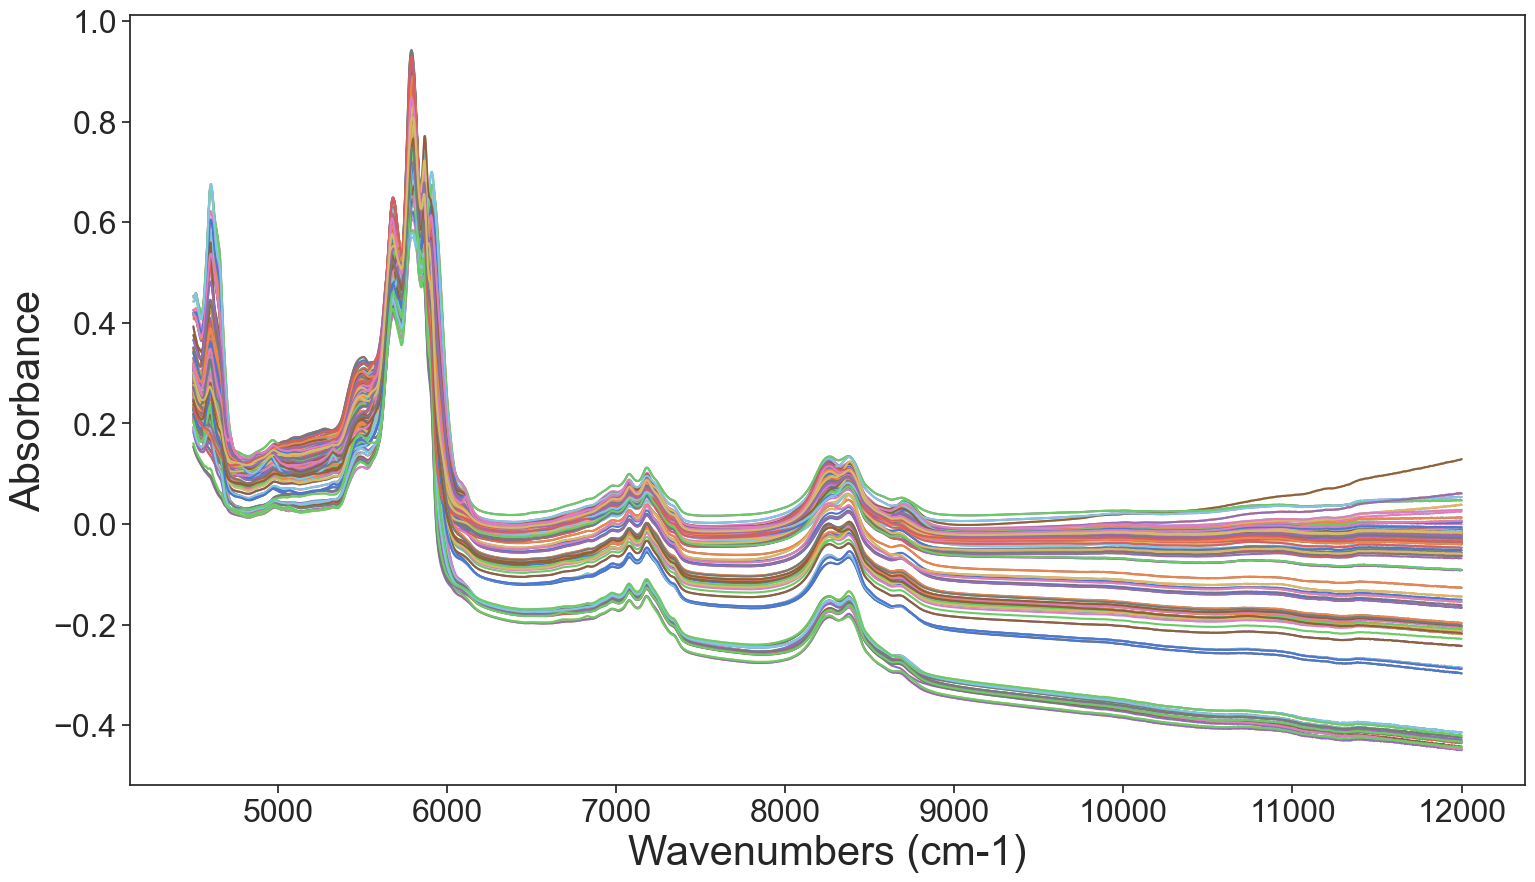

In [ ]:
""" MODEL LOGISTICS """
MODEL_NAME = 'IPA-Torch'
path_model = 'model/'

""" BASE HPs """
batch_size = 16
epochs = 500
initial_lr = .00025

""" REGULARIZATION HPs """
l2_lambda = .001

data = loadmat("data/raw-kennard-reduced_range.mat")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
W = data['Wcal'][0]


def plot_df(values, xlabel, fontsize=30):
    df = pd.DataFrame(values)
    df.columns = xlabel.T
    _, ax = plt.subplots(1, figsize=(18,10))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-7)

    ax.plot(df.transpose())
    plt.xlabel('Wavenumbers (cm-1)', fontsize=fontsize)
    plt.ylabel("Absorbance", fontsize=fontsize)
    plt.show()

plot_df(np.concatenate([X_train, X_test]), W)

In [4]:
scalerX = StandardScaler()
scalerY = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

X_train_reshaped = X_train.unsqueeze(1)
X_test_reshaped = X_test.unsqueeze(1)

train_loader = create_dataloader(X_train_reshaped, y_train, batch_size)
test_loader = create_dataloader(X_test_reshaped, y_test, batch_size)

Model does exist, performing regression.
RMSEC: 1.733
RMSEP: 1.387 - R2P: 0.990
Fit ratio: 1.249


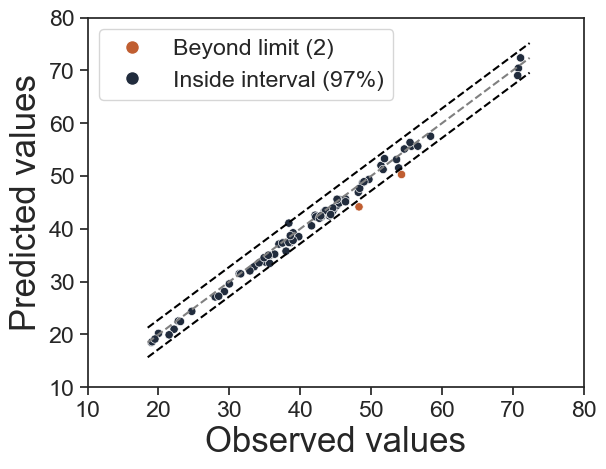

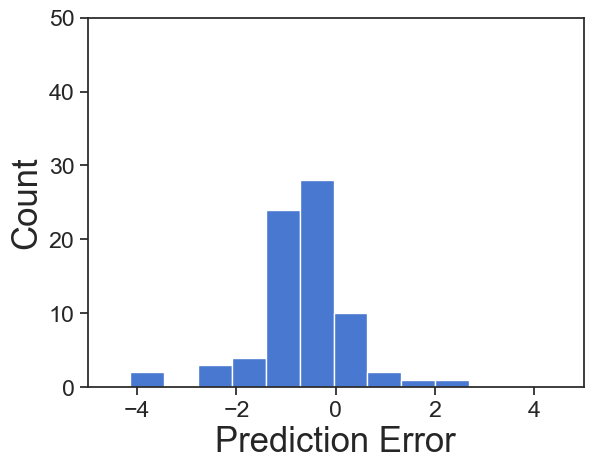

In [ ]:
if not os.path.exists(path_model + MODEL_NAME):
    # Initialize the model, loss function, and optimizer
    model = IPA().to(device)
    model = init_weights(model) # HeInitialization
    
    criterion_train = L1Loss()
    criterion_test = MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    decay_steps, decay_rate = 10000, 0.001 # Lr scheduler HPs
    lr_scheduler = ExponentialLR(optimizer, gamma=(1 - decay_rate) ** (1 / decay_steps))
    
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
        train_loss = train(model, device, train_loader, l2_lambda, criterion_train, optimizer, lr_scheduler)
        test_loss = test(model, device, test_loader, criterion_test)
    
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # Performance analysis - Calibration
    y_preds = np.array(model(X_train_reshaped).detach().cpu())
    rmsec = mean_squared_error(scalerY.inverse_transform(y_train_scaled), scalerY.inverse_transform(y_preds))
    print(f'RMSEC: {rmsec:.3f}')
    
    plot_training_history(train_losses, test_losses)

    full_path = f'{path_model}{MODEL_NAME}'
    print(f'Saving model in {full_path}')
    if not os.path.exists(full_path):
        os.makedirs(path_model)
    torch.save(model.state_dict(), full_path)

else:
    print('Model does exist, performing regression.')
    model = IPA().to(device)
    model.load_state_dict(torch.load(f'{path_model}{MODEL_NAME}'))

    # Performance analysis - Calibration
    y_preds = np.array(model(X_train_reshaped).detach().cpu())
    rmsec = mean_squared_error(scalerY.inverse_transform(y_train_scaled), scalerY.inverse_transform(y_preds))
    print(f'RMSEC: {rmsec:.3f}')

# Performance analysis - Validation
y_preds = np.array(model(X_test_reshaped).detach().cpu())
rmsep = mean_squared_error(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds))
r2 = r2_score(scalerY.inverse_transform(y_test_scaled), scalerY.inverse_transform(y_preds))
print(f"RMSEP: {rmsep:.3f} - R2P: {r2:.3f}")
print(f'Fit ratio: {rmsec/rmsep:.3f}')

plot_val(scalerY.inverse_transform(y_test_scaled),
         scalerY.inverse_transform(y_preds), 
         rmse_limit=2.8, axes=[10, 80])

plot_err(scalerY.inverse_transform(y_test_scaled), 
         scalerY.inverse_transform(y_preds), 
         deviation=5, bins=10, n_count=50)


In [6]:
X_train.shape, X_test.shape

(torch.Size([174, 3890]), torch.Size([75, 3890]))

## Feature relevance

In [7]:
input_sample = X_train.unsqueeze(1)[:]
print(input_sample.shape)

ex = shap.DeepExplainer(model, input_sample)
shapley_values_raw = ex.shap_values(input_sample)
shap_values = shapley_values_raw.squeeze(1)

torch.Size([174, 1, 3890])


### Overview

In [8]:
from matplotlib.patches import Patch

def lineplot_shapley(df, fontsize=20, palette=['#1e89e4'], labels = ['Absolute SVs']):
    _, ax1 = plt.subplots(1, figsize=(18,10))
    line1 = sns.lineplot(df.T, legend=False, palette=[palette[0]])
    plt.xlabel("Wavenumbers (cm-1)", fontsize=fontsize)
    plt.ylabel(labels[0], fontsize=fontsize)
    
    legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(palette, labels)]
    plt.show()

def compute_moving_average(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

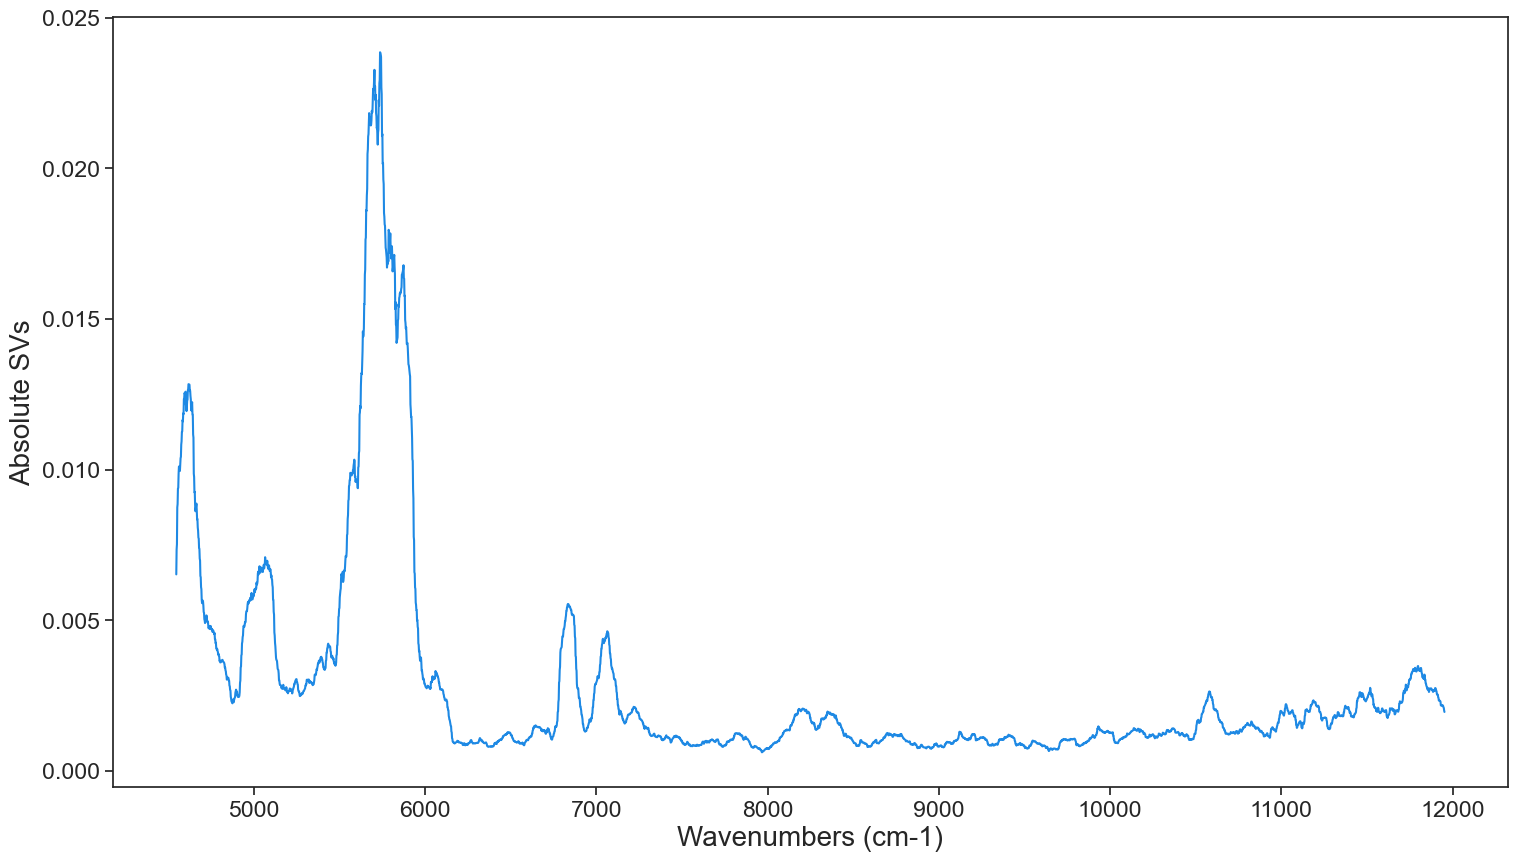

In [9]:
window = 50
mean_absolute_features = np.average(np.abs(shap_values), axis=0)
moving_average_features = compute_moving_average(mean_absolute_features, window)
moving_average_W = compute_moving_average(W, window)

df_ma = pd.DataFrame(moving_average_features).T
df_ma.columns = moving_average_W

lineplot_shapley(df_ma, palette=['#1e89e4'])

In [10]:
def lineplot_shapley(df, fontsize=30, palette=['#585153'], legend=False):
    """
    Parameters:
    - df : DataFrame pandas contenant les valeurs de Shapley (chaque ligne est une courbe).
    - fontsize : Taille de la police pour les axes.
    - palette : Palette de couleurs pour les courbes.
    """
    _, ax = plt.subplots(1, figsize=(18,10))
    
    # Tracer chaque ligne individuellement avec une étiquette
    for idx, row in df.iterrows():
        ax.plot(df.columns, row.values, label=f'{idx}')
    
    ax.set_xlabel("Wavenumbers (cm-1)", fontsize=fontsize)
    ax.set_ylabel('Absolute shapley values', fontsize=fontsize)
    
    if legend:
        ax.legend(fontsize=fontsize-10, title='Sample', title_fontsize=fontsize-5)
    
    # Ajuster la taille des ticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize-5)
    
    plt.tight_layout()
    plt.show()

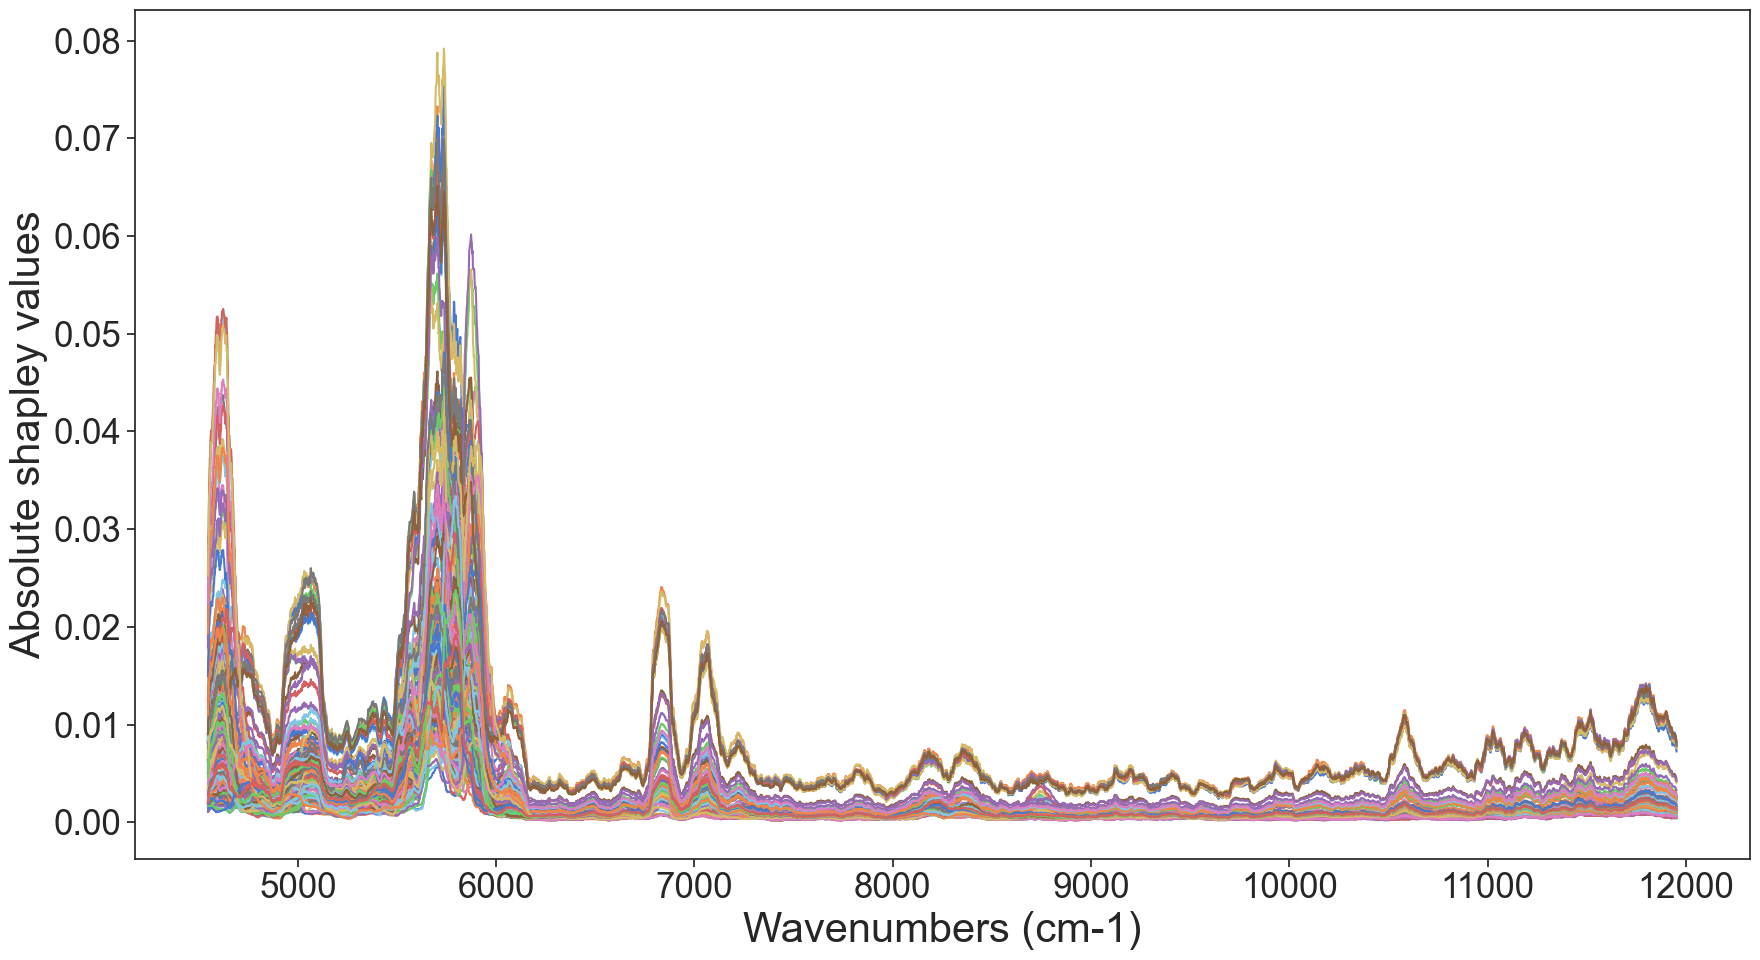

In [11]:
window = 50
absolute_features = np.abs(shap_values)
absolute_features_processed = []

for i in absolute_features:
    moving_average_features = compute_moving_average(i, window)
    absolute_features_processed.append(moving_average_features)

moving_average_W = compute_moving_average(W, window)
absolute_features_processed = np.array(absolute_features_processed)

df_ma = pd.DataFrame(absolute_features_processed)
df_ma.columns = moving_average_W

lineplot_shapley(df_ma, palette='muted')

### Baseline analysis

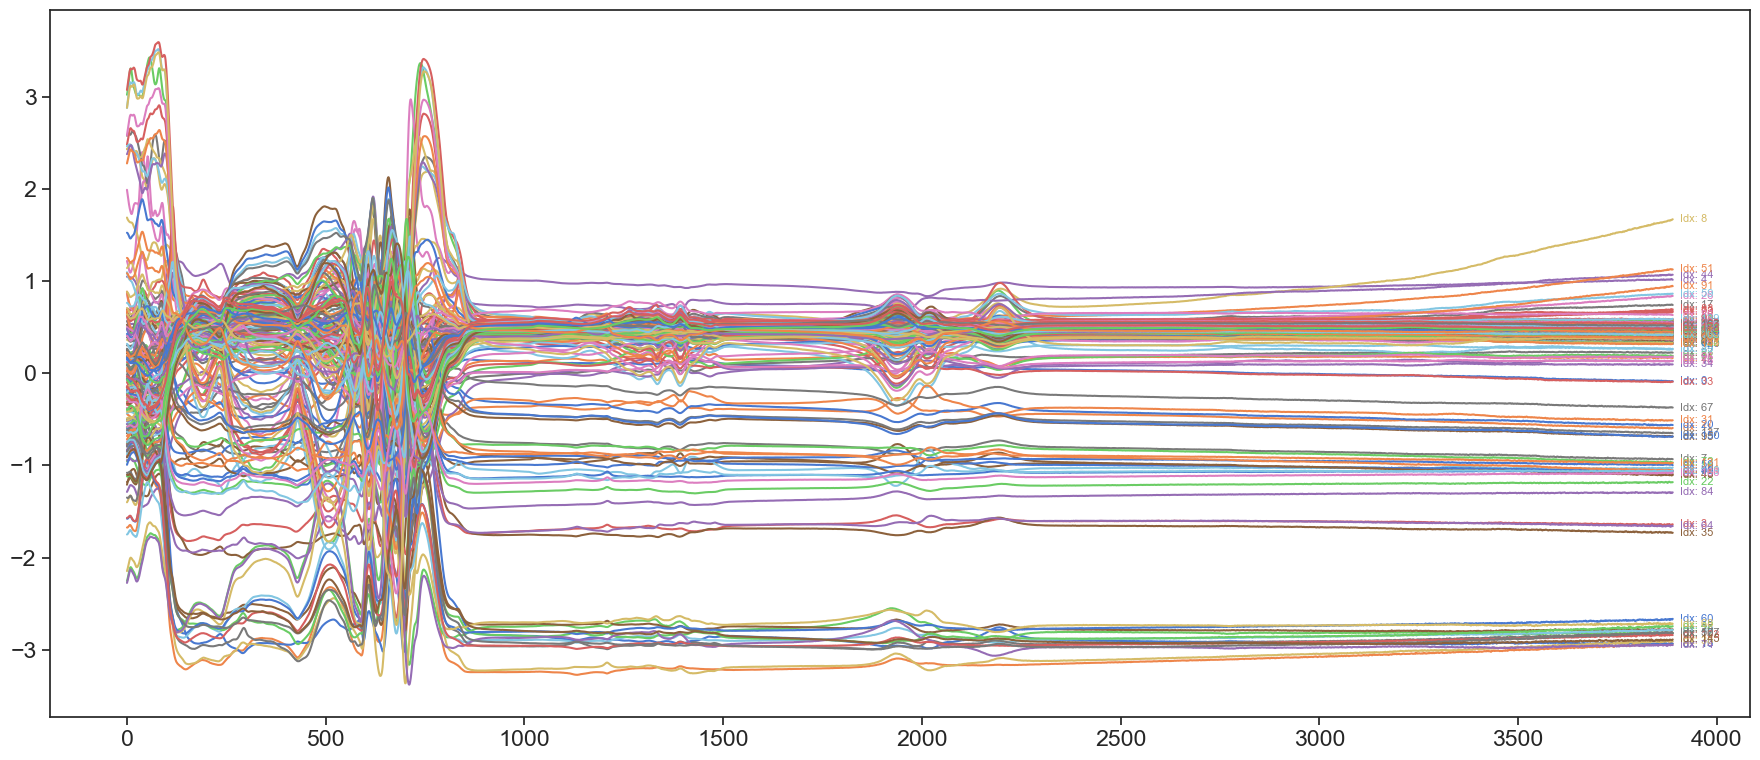

idx_with_baseline: [1, 10, 12, 25, 38, 39, 42, 57, 60, 68, 74, 103, 107, 145]


In [12]:
def baseline_analysis(X, limit=-.2):
    idx_with_baseline = []
    _, ax = plt.subplots(1, figsize=(18,8))
    
    for i in range(len(X)):
        line = plt.plot(X[i].T, label=i)
        
        # Get the last x and y coordinates of the line
        x_end = len(X[i].T) - 1
        y_end = X[i].T[-1]
        
        if y_end < limit: idx_with_baseline.append(i)
        
        # Add annotation at the end of each line
        ax.annotate(f'Idx: {i}', 
                    xy=(x_end, y_end),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center',
                    fontsize=8,
                    color=line[0].get_color())  # Match annotation color to line color
    
    # Adjust layout to prevent clipping of annotations
    plt.tight_layout()
    plt.show()
    
    print(f'idx_with_baseline: {idx_with_baseline}')
    return idx_with_baseline

idx_with_baseline = baseline_analysis(X_train.detach().cpu(), limit=-2.5)

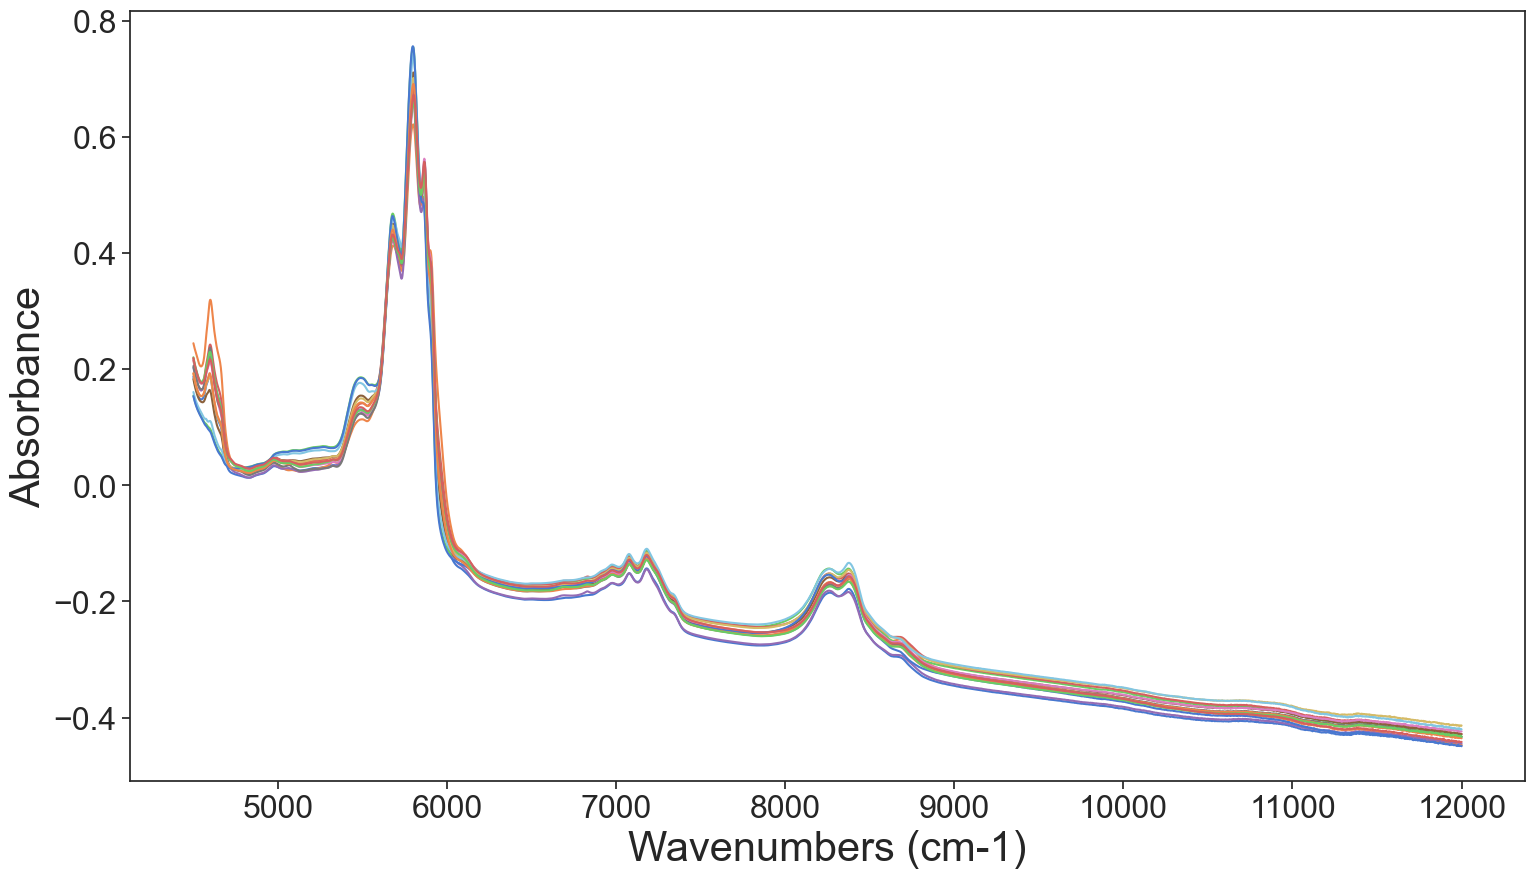

In [13]:
plot_df(scalerX.inverse_transform(X_train.cpu().detach())[idx_with_baseline], W)

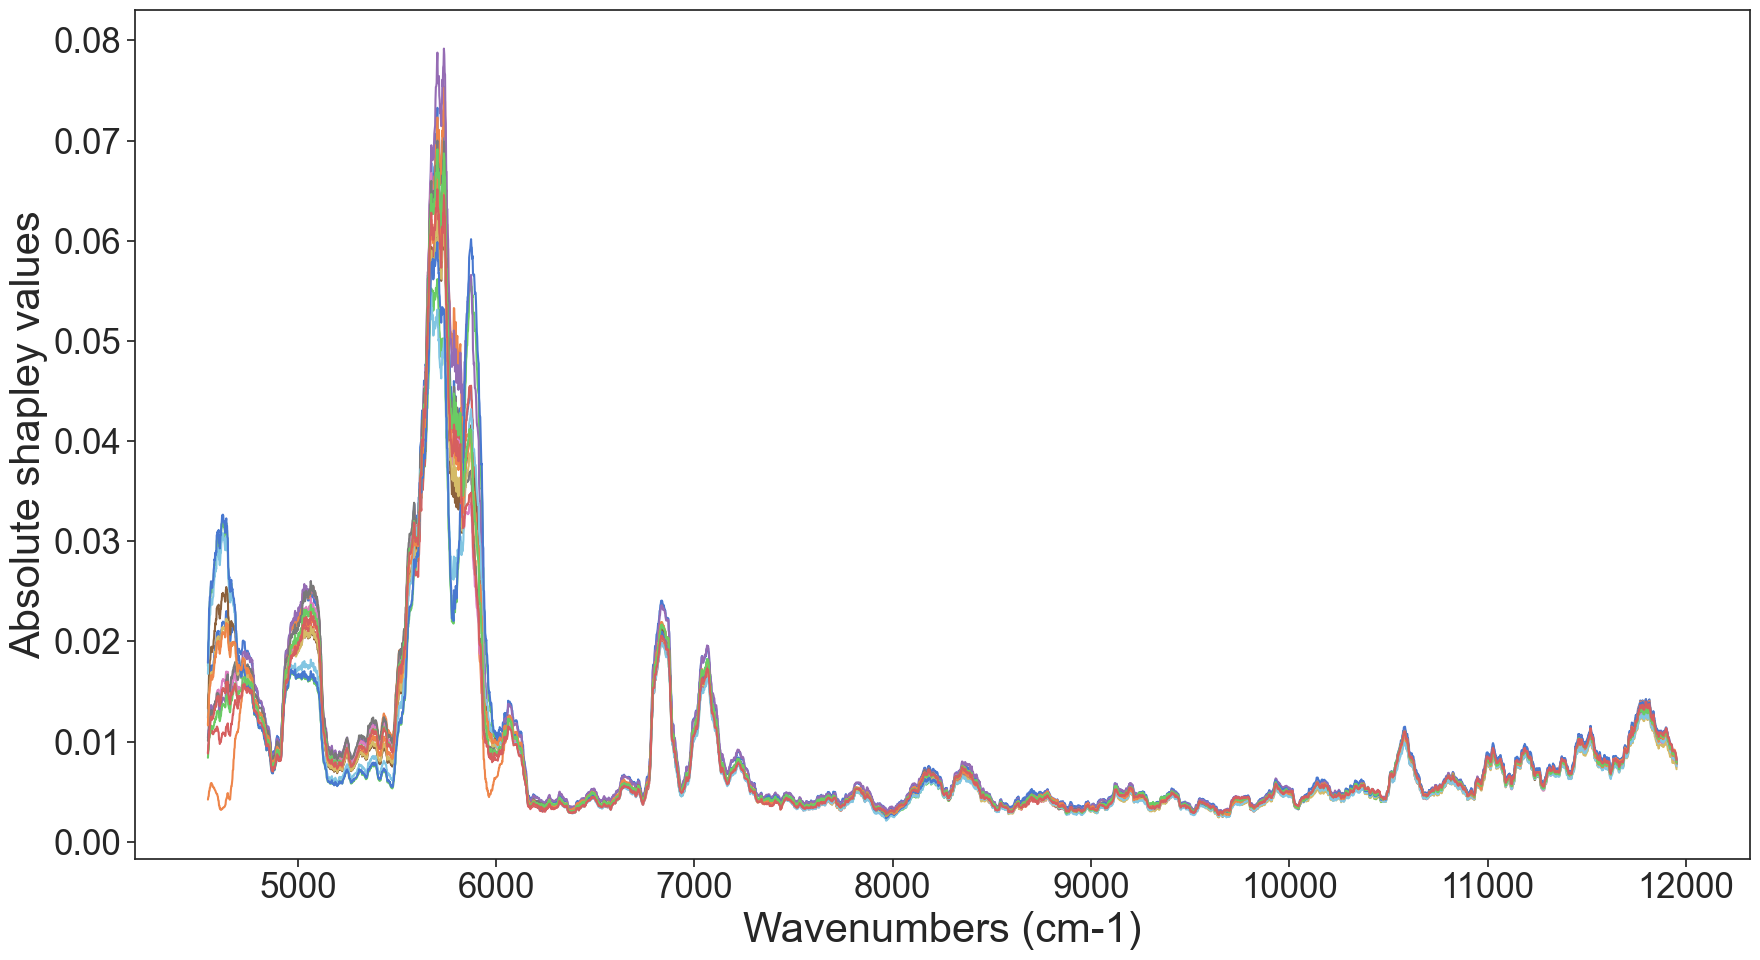

In [14]:
lineplot_shapley(df_ma.iloc[idx_with_baseline], palette='muted', legend=False)

In [15]:
y_outliers = scalerY.inverse_transform(y_train_scaled[idx_with_baseline])
print(f'Nbr: {len(idx_with_baseline)}, Min:{np.min(y_outliers):.2f}, Mean:{np.mean(y_outliers):.2f}, Max:{np.max(y_outliers):.2f}')

Nbr: 14, Min:35.70, Mean:43.33, Max:54.60
